# Implementing Decision Trees From Scratch

Training Accuracy: 1.0


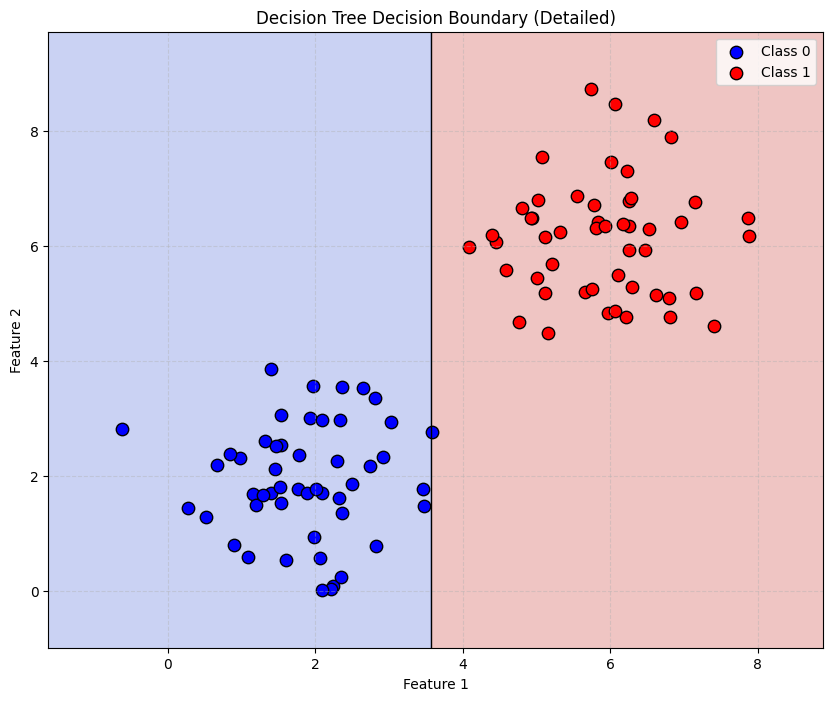

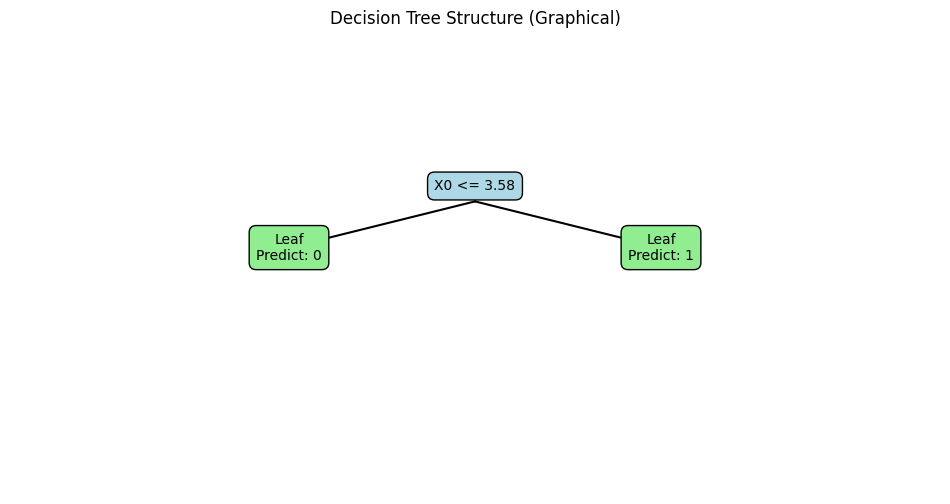

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# 1) Entropy Function
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-10))

# 2) Information Gain
def information_gain(X_column, y, split_val):
    left_idx = X_column <= split_val
    right_idx = X_column > split_val

    if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
        return 0

    left_entropy = entropy(y[left_idx])
    right_entropy = entropy(y[right_idx])

    n = len(y)
    n_l = len(y[left_idx])
    n_r = len(y[right_idx])

    child_entropy = (n_l/n)*left_entropy + (n_r/n)*right_entropy
    return entropy(y) - child_entropy

# 3) Decision Tree Class
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value   # leaf label


class DecisionTree:
    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _best_split(self, X, y):
        best_gain = -1
        best_feat = None
        best_thresh = None

        for feature in range(X.shape[1]):
            values = np.unique(X[:, feature])
            for threshold in values:
                gain = information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feature
                    best_thresh = threshold

        return best_feat, best_thresh, best_gain

    def _build_tree(self, X, y):
        # If only one class remains → leaf
        if len(np.unique(y)) == 1:
            return Node(value=y[0])

        feature, threshold, gain = self._best_split(X, y)

        if gain == 0:
            # No further split possible
            values, counts = np.unique(y, return_counts=True)
            return Node(value=values[np.argmax(counts)])

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        left = self._build_tree(X[left_idx], y[left_idx])
        right = self._build_tree(X[right_idx], y[right_idx])

        return Node(feature, threshold, left, right)

    def predict_one(self, x):
        node = self.root
        while node.value is None:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])
    
    # 4) Generate Synthetic Dataset (2 classes)

    np.random.seed(42)
    class0 = np.random.randn(50, 2) + np.array([2, 2])
    class1 = np.random.randn(50, 2) + np.array([6, 6])

    X = np.vstack([class0, class1])
    y = np.array([0]*50 + [1]*50)

    tree = DecisionTree()
    tree.fit(X, y)

    pred = tree.predict(X)
    acc = (pred == y).mean()
    print("Training Accuracy:", acc)

# Visualization 1) Decision Boundary Grid

def plot_decision_boundary_detailed(model, X, y):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = np.array([model.predict_one(point) for point in grid])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10,8))
    # Colored decision regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    # Contour lines for boundaries
    plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)

    # Plot training points with different markers
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c='blue', edgecolor='k', s=80, label='Class 0')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c='red', edgecolor='k', s=80, label='Class 1')

    plt.title("Decision Tree Decision Boundary (Detailed)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(alpha=0.4, linestyle="--")
    plt.legend()
    plt.show()

plot_decision_boundary_detailed(tree, X, y)

# Visualization 2) Tree Plot

def plot_tree_graphical(node, x=0, y=0, dx=4, dy=2, ax=None, depth=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    
    if node.value is not None:
        # Draw leaf node
        ax.text(x, y, f"Leaf\nPredict: {node.value}", ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", fc="lightgreen", ec="k", lw=1))
    else:
        # Draw decision node
        ax.text(x, y, f"X{node.feature} <= {node.threshold:.2f}", ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", ec="k", lw=1))
        # Draw left child
        ax.plot([x, x-dx], [y-0.5, y-dy], 'k-')
        plot_tree_graphical(node.left, x-dx, y-dy, dx/1.5, dy, ax, depth+1)
        # Draw right child
        ax.plot([x, x+dx], [y-0.5, y-dy], 'k-')
        plot_tree_graphical(node.right, x+dx, y-dy, dx/1.5, dy, ax, depth+1)
    
    if depth == 0:
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 5)
        ax.axis('off')
        plt.title("Decision Tree Structure (Graphical)")
        plt.show()

plot_tree_graphical(tree.root)